Mounted at /content/drive
GRAPE directory already exists
[Errno 2] No such file or directory: 'GRAPE_PATH'
/content


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std    	avg  	gen	max	min	nevals	std    
0  	200   	8.005	0  	11 	4  	200   	0.57877	23.02	0  	57 	5  	200   	12.8168
1  	129   	7.895	1  	10 	4  	129   	0.560335	22.055	1  	78 	3  	129   	13.1462
2  	115   	7.7  	2  	10 	4  	115   	0.883176	21.455	2  	57 	1  	115   	12.293 
3  	115   	7.495	3  	10 	4  	115   	1.09086 	23.585	3  	63 	1  	115   	12.7504
4  	111   	7.275	4  	12 	4  	111   	1.30743 	25.54 	4  	63 	1  	111   	14.4204
5  	117   	7.1  	5  	12 	2  	117   	1.41421 	27.88 	5  	83 	1  	117   	16.2174
6  	104   	6.71 	6  	12 	2  	104   	1.56394 	32.165	6  	82 	2  	104   	15.7069
7  	128   	6.45 	7  	12 	2  	128   	1.58981 	34.385	7  	86 	2  	128   	16.1909
8  	127   	6.5  	8  	12 	3  	127   	1.65529 	32.3  	8  	86 	2  	127   	16.9641


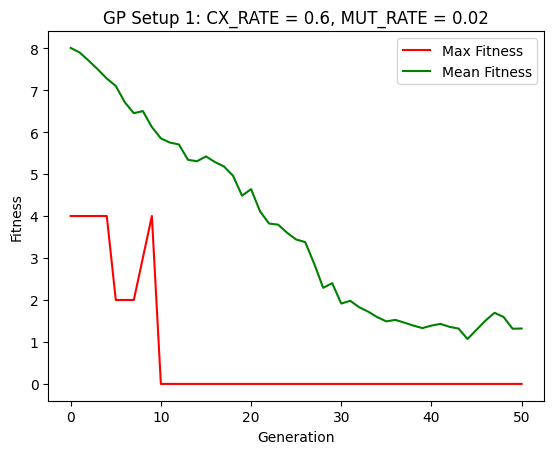

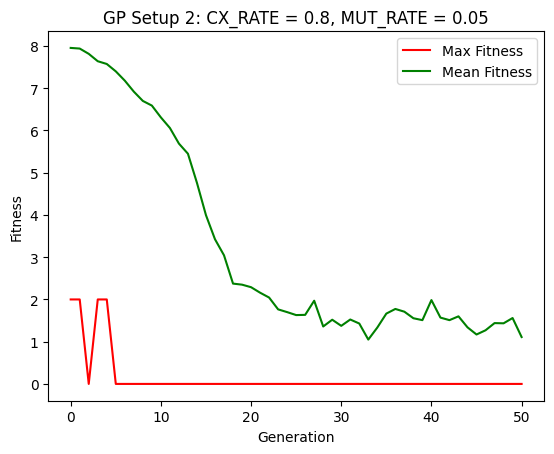

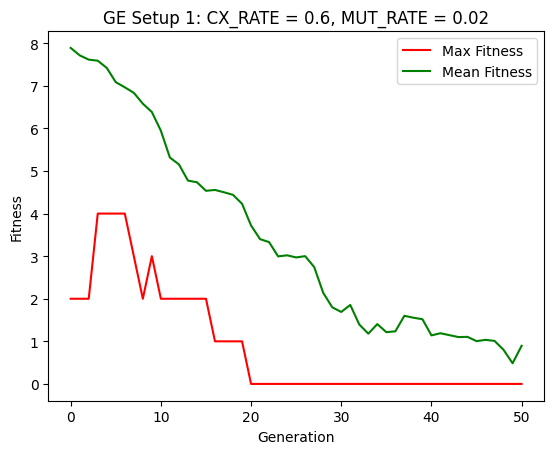

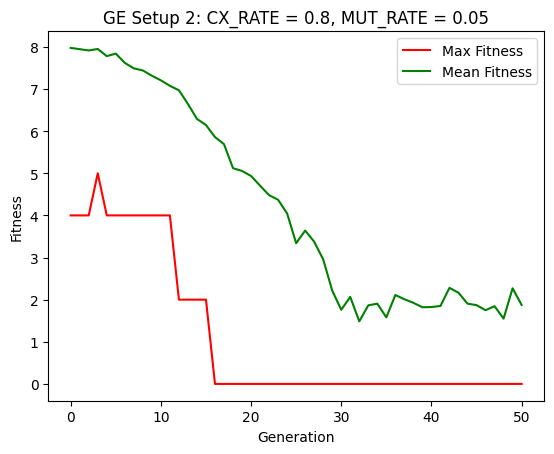

-- Best Individual (GP Setup 1) = xor(and_(1, IN2), xor(and_(or_(1, and_(IN2, xor(IN3, IN0))), xor(IN3, IN0)), xor(IN1, 0))), Fitness = 0.0
-- Best Individual (GP Setup 2) = and_(or_(IN1, not_(and_(IN2, and_(or_(IN1, and_(xor(IN0, IN0), and_(xor(IN0, IN0), xor(1, IN2)))), not_(and_(or_(IN3, IN0), not_(IN3))))))), xor(xor(IN2, IN1), xor(IN3, IN0))), Fitness = 0.0
-- Best Individual (GE Setup 1) = xor(xor(xor(xor(IN2, IN0), and_(0, IN1)), not_(xor(IN3, IN1))), or_(not_(xor(and_(IN1, IN1), and_(not_(and_(not_(or_(IN1, IN0)), xor(or_(xor(IN1, xor(or_(IN2, IN0), xor(IN1, IN2))), or_(0, IN0)), xor(IN1, IN2)))), IN3))), or_(and_(xor(IN3, IN3), xor(IN3, IN1)), or_(xor(xor(not_(IN1), not_(IN3)), IN1), or_(0, 1))))), Fitness = 0.0
-- Best Individual (GE Setup 2) = xor(xor(and_(xor(IN0, 1), not_(IN0)), or_(or_(IN2, 0), or_(0, 1))), xor(or_(xor(or_(or_(IN2, 0), or_(IN1, IN2)), not_(xor(1, IN2))), xor(or_(or_(or_(or_(0, IN3), not_(and_(IN2, not_(IN0)))), not_(xor(IN1, and_(not_(IN3), or_(IN2, xor(I

In [7]:
# Mount Google Drive and set up GRAPE library
from google.colab import drive
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import warnings
from IPython.core.display import display, HTML
from deap import base, creator, tools, gp, algorithms

# Suppress warnings
warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path for GRAPE repository
GRAPE_PATH = '/content/drive/MyDrive/grape/'

# Clone the GRAPE repository if it doesn't exist
if not os.path.exists(GRAPE_PATH):
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git
    print('Cloning GRAPE in your Drive')
else:
    print('GRAPE directory already exists')

%cd GRAPE_PATH

# Install required libraries
!pip install grape
!pip install deap

# Set display width for Jupyter notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

# Constants for Genetic Programming (GP)
GP_CONFIG = {
    "POP_SIZE": 200,
    "NUM_GENERATIONS": 50,
    "HOF_SIZE": 10,
    "SEED": 42,
    "TREE_MIN_HEIGHT": 3,
    "TREE_MAX_HEIGHT": 5,
    "TREE_LIMIT": 17,
    "MUT_TREE_MIN_HEIGHT": 0,
    "MUT_TREE_MAX_HEIGHT": 2
}
random.seed(GP_CONFIG["SEED"])

# Constants for Grammatical Evolution (GE)
GE_CONFIG = {
    "POP_SIZE": 200,
    "NUM_GENERATIONS": 50,
    "HOF_SIZE": 10,
    "GENOME_LENGTH": 10,
    "INPUT_DIM": 4  # For 4-bit parity
}
NUM_PATTERNS = 2 ** GE_CONFIG["INPUT_DIM"]

# Generate input patterns and expected outputs for parity check
input_patterns = list(itertools.product([0, 1], repeat=GE_CONFIG["INPUT_DIM"]))
expected_outputs = [sum(pattern) % 2 for pattern in input_patterns]

# Function to compute parity error for an individual
def compute_parity_error(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*inputs) != expected for inputs, expected in zip(input_patterns, expected_outputs))

# Fitness evaluation function for GP
def fitness_evaluation(individual):
    return compute_parity_error(individual),

# Define the primitive set for GP
pset = gp.PrimitiveSet("MAIN", GE_CONFIG["INPUT_DIM"], "IN")
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.xor, 2)
pset.addPrimitive(operator.not_, 1)
pset.addTerminal(1)
pset.addTerminal(0)

# Create toolbox for GP
toolbox = base.Toolbox()

# Define single-objective minimization strategy for GP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Register functions in the toolbox
toolbox.register("expr", gp.genFull, pset=pset, min_=GP_CONFIG["TREE_MIN_HEIGHT"], max_=GP_CONFIG["TREE_MAX_HEIGHT"])
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", fitness_evaluation)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=GP_CONFIG["MUT_TREE_MIN_HEIGHT"], max_=GP_CONFIG["MUT_TREE_MAX_HEIGHT"])
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Bloat control to limit tree height
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=GP_CONFIG["TREE_LIMIT"]))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=GP_CONFIG["TREE_LIMIT"]))

# Define the grammar for Grammatical Evolution
grammar = {0: "AND", 1: "OR", 2: "XOR", 3: "NOT", 4: "0", 5: "1"}

# Define GE individual as an integer list
creator.create("GEIndividual", list, fitness=creator.FitnessMin)
toolbox.register("ge_individual", tools.initRepeat, creator.GEIndividual, random.randint, a=0, b=5, n=GE_CONFIG["GENOME_LENGTH"])

# Function to map genotype to phenotype for GE
def map_to_phenotype(genotype):
    return [grammar[gene] for gene in genotype]

# Fitness evaluation function for GE
def ge_fitness_evaluation(individual):
    phenotype = map_to_phenotype(individual)
    func = toolbox.compile(expr=phenotype)
    return sum(func(*inputs) != expected for inputs, expected in zip(input_patterns, expected_outputs)),

toolbox.register("ge_evaluate", ge_fitness_evaluation)

# Register genetic operators for GE
toolbox.register("ge_select", tools.selTournament, tournsize=2)
toolbox.register("ge_mate", tools.cxOnePoint)
toolbox.register("ge_mutate", tools.mutUniformInt, low=0, up=5, indpb=0.1)

# Function to run GP experiments
def run_gp_experiment(cross_prob, mut_prob):
    population = toolbox.population(n=GP_CONFIG["POP_SIZE"])
    hof = tools.HallOfFame(GP_CONFIG["HOF_SIZE"])

    # Gather statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    combined_stats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    combined_stats.register("avg", np.mean)
    combined_stats.register("std", np.std)
    combined_stats.register("min", np.min)
    combined_stats.register("max", np.max)

    # Run the evolutionary algorithm
    population, log = algorithms.eaSimple(population, toolbox, cxpb=cross_prob, mutpb=mut_prob,
                                           ngen=GP_CONFIG["NUM_GENERATIONS"], stats=combined_stats, halloffame=hof, verbose=True)

    return hof, log

# Function to run GE experiments
def run_ge_experiment(cross_prob, mut_prob):
    ge_population = toolbox.population(n=GE_CONFIG["POP_SIZE"])
    ge_hof = tools.HallOfFame(GE_CONFIG["HOF_SIZE"])

    # Gather statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    combined_stats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    combined_stats.register("avg", np.mean)
    combined_stats.register("std", np.std)
    combined_stats.register("min", np.min)
    combined_stats.register("max", np.max)

    # Run the evolutionary algorithm
    ge_population, ge_log = algorithms.eaSimple(ge_population, toolbox, cxpb=cross_prob, mutpb=mut_prob,
                                                 ngen=GE_CONFIG["NUM_GENERATIONS"], stats=combined_stats, halloffame=ge_hof, verbose=True)

    return ge_hof, ge_log

# Run GP experiments with different crossover and mutation rates
hof_gp_1, log_gp_1 = run_gp_experiment(cross_prob=0.6, mut_prob=0.02)
hof_gp_2, log_gp_2 = run_gp_experiment(cross_prob=0.8, mut_prob=0.05)

# Run GE experiments with different crossover and mutation rates
hof_ge_1, log_ge_1 = run_ge_experiment(cross_prob=0.6, mut_prob=0.02)
hof_ge_2, log_ge_2 = run_ge_experiment(cross_prob=0.8, mut_prob=0.05)

# Function to plot fitness results
def plot_fitness(logbook, title):
    max_fit, mean_fit = logbook.chapters['fitness'].select("min", "avg")
    plt.plot(max_fit, color='r', label='Max Fitness')
    plt.plot(mean_fit, color='g', label='Mean Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot results for GP
plot_fitness(log_gp_1, "GP Setup 1: CX_RATE = 0.6, MUT_RATE = 0.02")
plot_fitness(log_gp_2, "GP Setup 2: CX_RATE = 0.8, MUT_RATE = 0.05")

# Plot results for GE
plot_fitness(log_ge_1, "GE Setup 1: CX_RATE = 0.6, MUT_RATE = 0.02")
plot_fitness(log_ge_2, "GE Setup 2: CX_RATE = 0.8, MUT_RATE = 0.05")

# Function to print best individuals
def print_best(hof, setup_name):
    best_individual = hof.items[0]
    print(f"-- Best Individual ({setup_name}) = {best_individual}, Fitness = {best_individual.fitness.values[0]}")

# Print best individuals from GP and GE experiments
print_best(hof_gp_1, "GP Setup 1")
print_best(hof_gp_2, "GP Setup 2")
print_best(hof_ge_1, "GE Setup 1")
print_best(hof_ge_2, "GE Setup 2")